# PyTorch Tutorial #01

# Simple Linear Model

## Introduction

This tutorial demonstrates the basic workflow of using PyTorch with a simple linear model. After loading the so-called MNIST data-set with images of hand-written digits, we define and optimize a simple mathematical model in PyTorch. The results are then plotted and discussed.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. It also helps if you have a basic understanding of Machine Learning and classification.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook,trange

import torch
from torch.nn import Parameter
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import SGD

In [2]:
torch.__version__

'0.4.1'

## Load Data

For loading and preprocessing data we will using a Library called `torchvison`

It will automatically download and preprocess the images. Preprocessing is done based on the `transform_func`.

Transforms are common image transforms. They can be chained together using `Compose`

Here we are Applying 2 transformation to images
1. Reading and Converting images into Pytorch Tensors
2. Normalise the images based on the mean and std

In [3]:
# Transformer function for image preprocessing
transforms_func = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# mnist train_set
mnist_train = MNIST('./data',train=True,download=True,transform=transforms_func)

# mnist test_set
mnist_test = MNIST('./data',train=False,transform=transforms_func)

## Creating a validation set

Here we are spliting the training data to `mnist_train` and `mnist_valid`
A validation set can be used to check the model is overfittig or not on th e training set and accordingly stop training process or save intermediate model weights

In [4]:
train_len = int(0.9*mnist_train.__len__())
valid_len = mnist_train.__len__() - train_len
mnist_train, mnist_valid = torch.utils.data.random_split(mnist_train, lengths=[train_len, valid_len])

The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(mnist_train.__len__()))
print("- Validation-set:\t{}".format(mnist_valid.__len__()))
print("- Test-set:\t\t{}".format(mnist_test.__len__()))

Size of:
- Training-set:		54000
- Validation-set:	6000
- Test-set:		10000


In [6]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = 784 # 28 x 28

# Tuple with height and width of images used to reshape arrays.
img_shape = (28,28)

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Plot a few images to see if data is correct

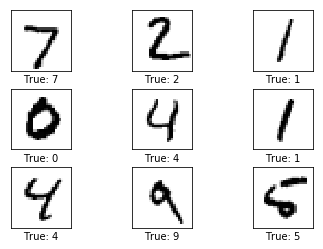

In [8]:
# Get the first images from the test-set.
images = mnist_test.test_data[0:9]

# Get the true classes for those images.
cls_true = mnist_test.test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# PyTorch
PyTorch is a Python package that provides two high-level features:

1. Tensor computation (like NumPy) with strong GPU acceleration
2. Deep neural networks built on a tape-based autograd system

You can reuse your favorite Python packages such as NumPy, SciPy and Cython to extend PyTorch when needed.

## More about PyTorch

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| **torch** | a Tensor library like NumPy, with strong GPU support |
| **torch.autograd** | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| **torch.nn** | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| **torch.multiprocessing** | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| **torch.utils** | DataLoader, Trainer and other utility functions for convenience |
| **torch.legacy(.nn/.optim)** | legacy code that has been ported over from torch for backward compatibility reasons |

Usually one uses PyTorch either as:

- a replacement for NumPy to use the power of GPUs.
- a deep learning research platform that provides maximum flexibility and speed

### Dynamic Neural Networks: Tape-Based Autograd

PyTorch has a unique way of building neural networks: using and replaying a tape recorder.

Most frameworks such as TensorFlow, Theano, Caffe and CNTK have a static view of the world.
One has to build a neural network, and reuse the same structure again and again.
Changing the way the network behaves means that one has to start from scratch.

With PyTorch, we use a technique called reverse-mode auto-differentiation, which allows you to
change the way your network behaves arbitrarily with zero lag or overhead. Our inspiration comes
from several research papers on this topic, as well as current and past work such as
[torch-autograd](https://github.com/twitter/torch-autograd),
[autograd](https://github.com/HIPS/autograd),
[Chainer](http://chainer.org), etc.

While this technique is not unique to PyTorch, it's one of the fastest implementations of it to date.
You get the best of speed and flexibility for your crazy research.


# Recommended Reading
https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

# Neural Network

Neural networks can be constructed using the torch.nn package.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:    
`weight = weight - learning_rate * gradient`

# Model

We will define networks as a subclass of nn.Module

You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function.

The netowork we will be definning here will be containing a single Linear Layer.

The linear layer will contain 2 variables `weights` an `bias`, That must be changed by PyTorch so as to make the model perform better on the traning data

This simple mathematical model multiplies the images variable x with the weights and then adds the biases.

The result is a matrix of shape [num_images, num_classes] because x has shape [num_images, img_size_flat] and weights has shape [img_size_flat, num_classes], so the multiplication of those two matrices is a matrix with shape [num_images, num_classes] and then the biases vector is added to each row of that matrix.

### __init__( ) function
1. The first variable that must be optimized is called weights and is defined here as a Pytorch variable that must be initialized with zeros and whose shape is `[img_size_flat, num_classes]`, so it is a 2-dimensional tensor (or matrix) with img_size_flat rows and num_classes columns.
2. The second variable that must be optimized is called biases and is defined as a 1-dimensional tensor (or vector) of length num_classes.
3. Here in the __init__() function both weight and bias Tensors wrapped in as `Parameter`.Parameters are `Tensor` subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in `parameters()` iterator.

### froward( ) function
1. The forward function will taking input of shape `[num_images, img_size_flat]` and multiplying with `weight` of shape `[num_images, num_classes]` and the `bias`  is added to final result. We can use torch built in func call `torch.addmm()` for performing the above operation.It is similar to `tf.nn.xw_plus_b` in `Tensorflow`
2. The `out` in first line of `forward()` will have shape `[num_images, num_classes]`
3. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `out` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `out` it self.

```N.B The module `softmax` doesn’t work directly with NLLLoss, which expects the Log to be computed between the Softmax and itself. we will be Using LogSoftmax instead (it’s faster and has better numerical properties).```

Softmax has takes input Matrix and `dim`, A dimension along which Softmax will be computed (so every slice along dim will sum to 1).

### get_weights( )
1. This Function used to get the weights of the Network, To plot it understand what the model actually learned

In [9]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.weight = Parameter(torch.zeros((784, 10),dtype=torch.float32,requires_grad=True))
        self.bias = Parameter(torch.zeros((10),dtype=torch.float32,requires_grad=True))
        
    def get_weights(self):
        return self.weight
    
    def forward(self,x):
        out = torch.addmm(self.bias, x, self.weight)
        out = F.log_softmax(out,dim=1)
        return out

# Training Network

Function to train the Network
- Input:
    - model : model object
    
    - device : `cpu` or `cuda`
    
    - train_loader : Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the                    dataset.
    
    - optimizer : the function we are going to use for adjusting model parametrs

### Step by step

1. `model.train()`tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
2. `for loop` it will iterate through train_loader , it will give you 2 output `data` and `target`. The size of `data` and `target` will be depend on the `batch_size` that you have provided while creating the `DataLoader` function for `train dataset` . `data` shape `[batch_size,row,columns]`,`target` shape `[batch_size]` 
3. Here the `data` will be of shape `[batch_size,row,columns]` ,we will convert `data` in to `[batch_size,row x columns]`  (Flattening the images to fit into Linear layer)
4. Moving the the `data` and `target` to devices based on our choice and machine specifictaion. 
5. By calling `optimizer.zero_grad` we will set Gradient buffers to zero.Else the gradients will get  accumulated to existing gradients.
6. Input the `data` to `model` and get outputs, The output will be of shape `[batch_size,num_classes]`
7. `Loss function` : A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target . We will be using The negative log likelihood loss. It is useful to train a classification problem with C classes.
`nll_loss` function calculate the difference between the `output` to `target` , `output` of shape `[batch_size,num_classes]` and `target` of shape `[batch_size]`  where each value is `0 ≤ targets[i] ≤ num_classes−1`
8. when we call `loss.backward()`, the whole graph is differentiated w.r.t. the loss, and all Tensors in the graph that has `requires_grad=True` will have their `.grad` Tensor accumulated with the gradient.
9. To backpropagate the error all we have to do is to `loss.backward()`
10. `optimizer.step()` is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule.

In [1]:
def train(model,device,train_loader,optimizer):
    model.train()
    correct = 0
    for data,target in tqdm_notebook(train_loader,total=train_loader.__len__()):
        data = torch.reshape(data,(-1,784))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(train_loader.dataset),100. * correct / len(train_loader.dataset)))

# Testing Network

Function to test the Network
- Input:
    - model : model object
    
    - device : `cpu` or `cuda`
    
    - test_loader : Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the                    dataset.

### Step by step

1. `model.eval()` tells your model that you are testing the model.so that Regularization Layers like `Droupout` and `BatchNormalization` get disbaled ,which behave different on the train and test procedures.
2. The wrapper `with torch.no_grad()` temporarily set all the requires_grad flag to false. Because we don't need to compute gradinets while performaing inference on the network and It will reduce memory usage and speed up computations
3. The nex three line are same as Train function
4. we will calculate the test_loss across the complete dataset
5. we will also calcualte the `accuracy` of model by comapring with target

In [2]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i,(data, target) in tqdm_notebook(enumerate(test_loader),total=test_loader.__len__()):
            data, target = data.to(device), target.to(device)
            data = torch.reshape(data,(-1,784))
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Function to get predicted class for all the test set

In [12]:
def get_incorrect_samples(model, device, test_loader):
    model.eval()
    prediction = []
    correct = []
    with torch.no_grad():
        for i,(data, target) in tqdm_notebook(enumerate(test_loader),total=test_loader.__len__()):
            data, target = data.to(device), target.to(device)
            correct.extend(target)
            data = torch.reshape(data,(-1,784))
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            prediction.extend(pred)
    out = torch.tensor(test_loader.dataset.test_labels).eq(torch.tensor(prediction).view_as(test_loader.dataset.test_labels))
    return out.numpy(),np.asarray(prediction)

### Checking Device Availabilty 

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cpu'

## DataLoader function for Training Set  and Test Set
Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [15]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = DataLoader(mnist_train,batch_size=64,shuffle=True,**kwargs)
test_loader = DataLoader(mnist_test,batch_size=1024,shuffle=False,**kwargs)

# Model

Model object is created and Transfered to `device` accoring to availabilty of `GPU` 

In [16]:
model = LinearModel().to(device)

## Optimizer

We will be using `stochastic gradient descent|(SGD)` optimizer

`SGD` takes `model parameters` the we want to optimze and a learning_rate `lr` in which the model parametrs get updated

In [17]:
optimizer = SGD(model.parameters(),lr=0.5)

model parameters contains `weight` and `bias` that we defined inside our model , So while training the `weight` and `bias` will get updated according to our training set

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

## Training

`epoch` is 10 .So in training the model will get iterated through the complete Training set 10 times .

After each epoch we will run `test` and check how well the model is performing on unknown data

If the Training Accuracy is going Up and Testing Accuracy is going down we can say that model is overfitting on the train set. 

There are Techinques like `EarlyStopping` and usage of validatoin datset that we will discuss later

In [19]:
epochs = 2
for epoch in range(epochs):
        train(model,device,train_loader,optimizer)
        test(model,device,test_loader)

HBox(children=(IntProgress(value=0, max=844), HTML(value='')))


Accuracy: 45909/54000 (85%)



HBox(children=(IntProgress(value=0, max=10), HTML(value='')))



Test set: Average loss: 1.0363, Accuracy: 8714/10000 (87%)



HBox(children=(IntProgress(value=0, max=844), HTML(value='')))


Accuracy: 47269/54000 (88%)



HBox(children=(IntProgress(value=0, max=10), HTML(value='')))



Test set: Average loss: 0.8992, Accuracy: 8835/10000 (88%)



## Helper function to Plot Weights of the model

In [20]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = model.get_weights()
    w = w.detach().numpy()
    img_shape = (28,28)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

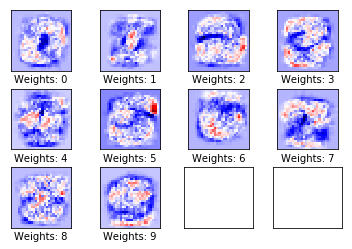

In [21]:
plot_weights()

In [22]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    #correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    #feed_dict=feed_dict_test)

    # Negate the boolean array.
    
    correct,cls_pred = get_incorrect_samples(model,'cpu',test_loader)
    
    incorrect = [i for i,x in enumerate(correct) if x==0] 
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = mnist_test.test_data.numpy()[incorrect]
#     import pdb;pdb.set_trace()
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = mnist_test.test_labels.numpy()[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

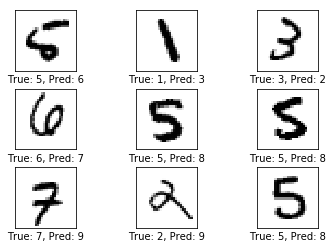

In [23]:
plot_example_errors()

## Helper function to Print Confusion Matrix

In [24]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = test_loader.dataset.test_labels
    
    # Get the predicted classifications for the test-set.
#     cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    _,cls_pred = get_incorrect_samples(model,'cpu',test_loader)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


[[ 944    0    1    1    0    6   25    2    1    0]
 [   0 1031    3    4    0    2    3    2   90    0]
 [  13    3  856    8    6    2   18    9  108    9]
 [   5    1   14  866    1   14    4   13   85    7]
 [   1    2    4    3  893    0   17    1   20   41]
 [  10    1    3   46   20  611   37    5  144   15]
 [   7    3    4    0    8    6  922    4    4    0]
 [   1    6   19    5    7    1    0  910    9   70]
 [  11    1    3   12   11   11   12    9  891   13]
 [   9    4    0    5   40    4    0   17   19  911]]


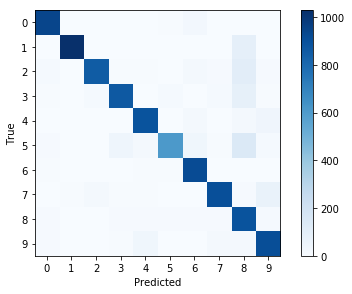

In [25]:
print_confusion_matrix()

## Exercises

These are a few suggestions for exercises that may help improve your skills with PyTorch. It is important to get hands-on experience with PyTorch in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

- Change the learning-rate for the optimizer.
- Change the optimizer to e.g. AdagradOptimizer or AdamOptimizer.
- Change the batch-size to e.g. 1 or 1000.
- How do these changes affect the performance?
- Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
- Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
- Change the function plot_example_errors() so it also prints the logits and y_pred values for the mis-classified examples.
- Use F.CrossEntropyLoss() instead of F.nll_loss. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
- Remake the program yourself without looking too much at this source-code.
- Explain to a friend how the program works.